In [1]:
import numpy as np
import pandas as pd
import torch
from kan import KAN


def undersample(data):
    # 提取特征和标签
    X = data[:, :-1]  # 特征
    y = data[:, -1]  # 标签

    # 计算每个类别的样本数量
    num_class_0 = np.sum(y == 0)
    num_class_1 = np.sum(y == 1)

    # 找出较少的类别样本数量
    minority_class = np.min([num_class_0, num_class_1])

    # 随机选择较多类别中与较少类别数量相同的样本，实现欠采样
    class_0_indices = np.where(y == 0)[0]
    class_1_indices = np.where(y == 1)[0]
    undersampled_indices = np.concatenate([np.random.choice(class_0_indices, minority_class, replace=False),
                                           np.random.choice(class_1_indices, minority_class, replace=False)])

    # 获取欠采样后的特征和标签
    X_undersampled = X[undersampled_indices]
    y_undersampled = y[undersampled_indices]

    # 欠采样后的数据
    undersampled_data = np.column_stack((X_undersampled, y_undersampled))

    np.random.shuffle(undersampled_data)

    return undersampled_data

if __name__ == "__main__":
    model = KAN([7, 10, 1], device="cuda")
    df = pd.read_csv("data_OK.csv")
    data = df.to_numpy().astype('float32')
    data = undersample(data)
    dataset = {}
    length = data.shape[0] // 10
    dataset['train_input'] = torch.from_numpy(data[:-length, 2:9]).to("cuda")
    dataset['test_input'] = torch.from_numpy(data[-length:, 2:9]).to("cuda")
    dataset['train_label'] = torch.from_numpy(data[:-length, 9]).reshape((-1, 1)).to("cuda")
    dataset['test_label'] = torch.from_numpy(data[-length:, 9]).reshape((-1, 1)).to("cuda")
    # print(dataset['train_input'].shape)
    # print(dataset['test_label'][0:20,:])
    # print(dataset['train_label'])



    def train_acc():
        return torch.mean((torch.round(model(dataset['train_input'])[:, 0]) == dataset['train_label'][:, 0]).float())


    def test_acc():
        return torch.mean((torch.round(model(dataset['test_input'])[:, 0]) == dataset['test_label'][:, 0]).float())

In [2]:
results = model.train(dataset, opt="LBFGS", steps=20, metrics=(train_acc, test_acc), device="cuda:0")

train loss: 4.68e-01 | test loss: 4.68e-01 | reg: 2.10e+01 : 100%|██| 20/20 [04:12<00:00, 12.63s/it]


In [3]:
print(results['train_acc'][-1])
print(results['test_acc'][-1])

0.6438846588134766
0.6389845609664917


In [61]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import os

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

# 设置其他字体属性，如字号
plt.rcParams.update({'font.size': 12})

def plot_confusion_matrix(cm, classes, idx, normalize=False, title='混淆矩阵', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("归一化混淆矩阵")
    else:
        print('混淆矩阵，未归一化')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for idx in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, idx, format(cm[idx, j], fmt),
                     horizontalalignment="center",
                     color="red" if cm[idx, j] > thresh else "red")

    plt.ylabel('真实类别')
    plt.xlabel('预测类别')
    
    # 打印指标
    plt.text(0, -0.8, f"预警准确度：{cm[1,1] / (cm[1,1] + cm[0,1]):.2f}", fontsize=12, ha='left', color='green')
    plt.text(0, -0.6, f"预警灵敏度：{cm[1,1] / (cm[1,1] + cm[1,0]):.2f}", fontsize=12, ha='left', color='green')
    plt.text(0, -0.4, f"整体准确度：{(cm[1,1] + cm[1,0]) / (cm[1,1] + cm[1,0] + cm[0,1] + cm[0,0]):.2f}", fontsize=12, ha='left', color='green')
    
    # 检查文件夹是否存在，不存在则创建
    folder = 'KAN'
    if not os.path.exists(folder):
        os.makedirs(folder)
    
    plt.savefig(os.path.join(folder, f'KAN_{i}.png'))
    plt.tight_layout()

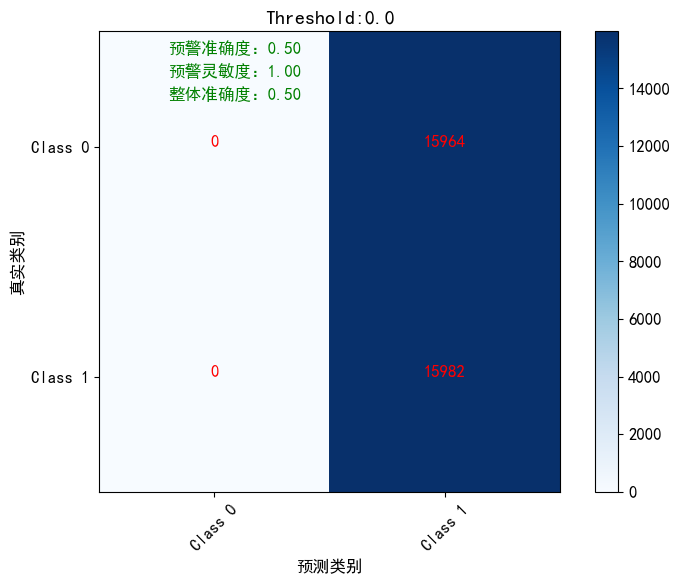

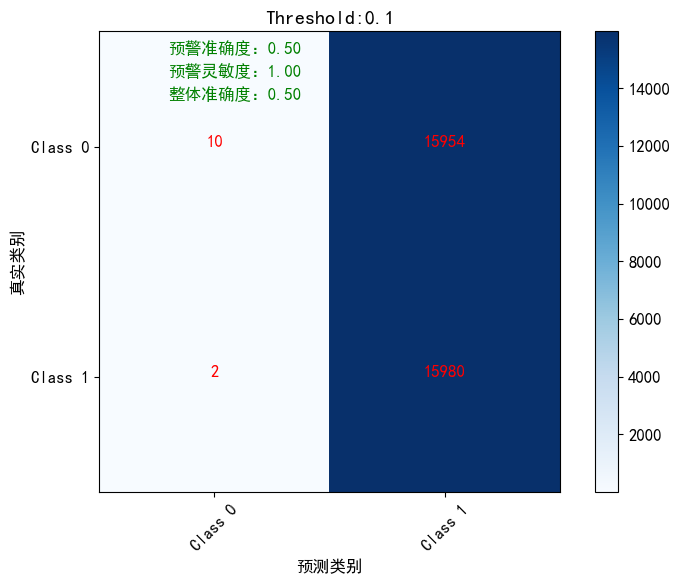

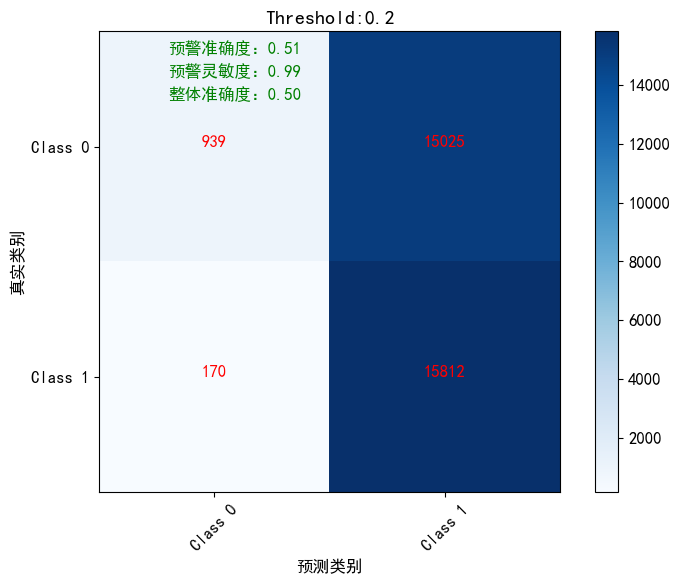

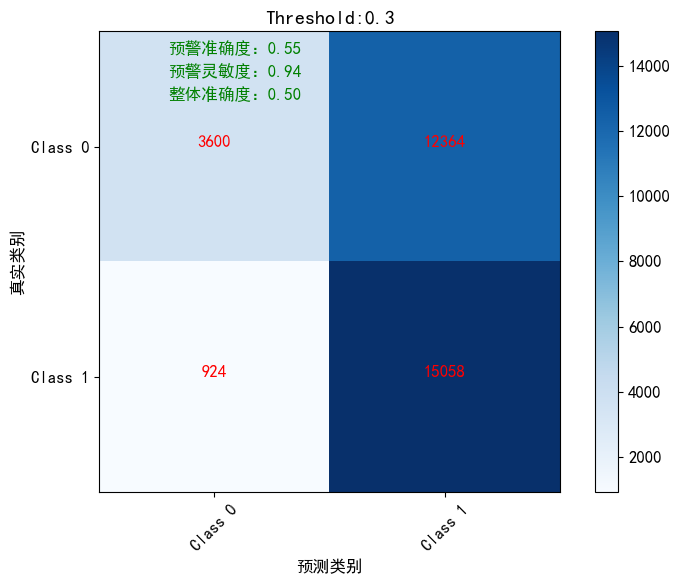

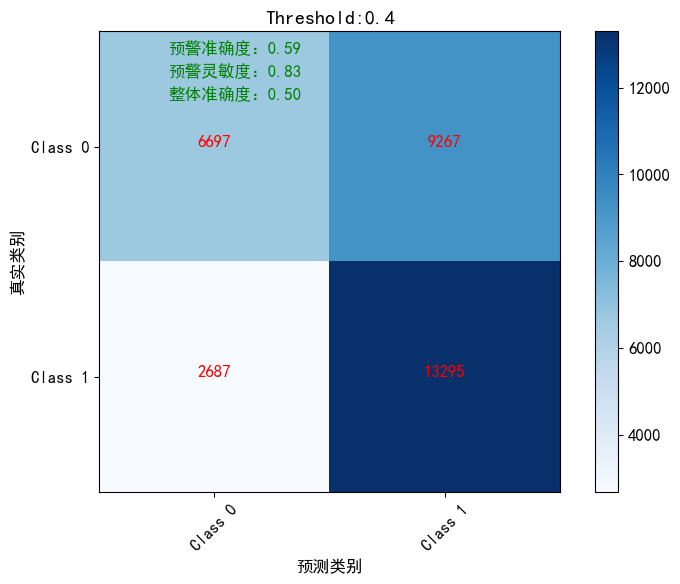

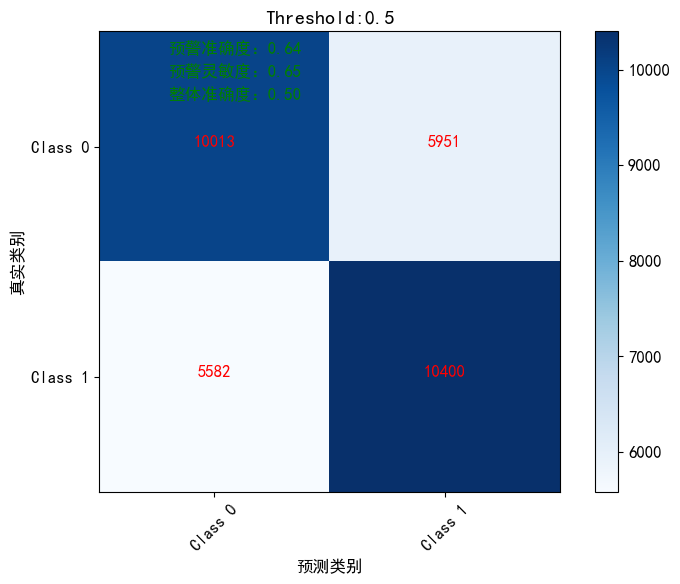

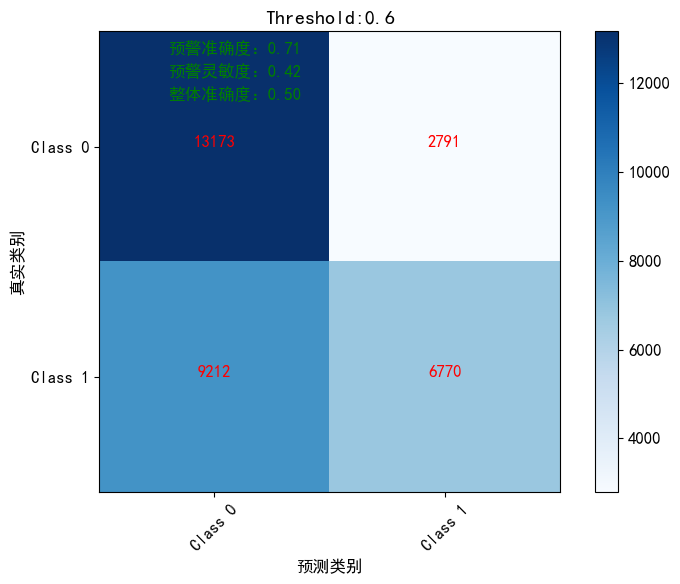

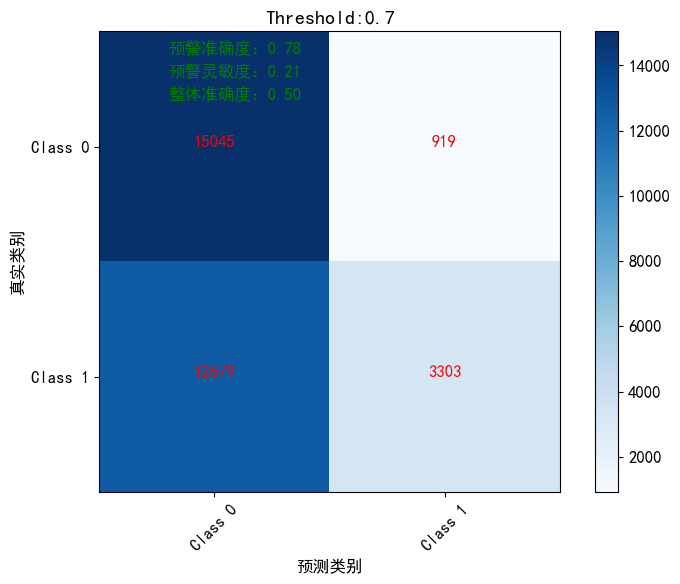

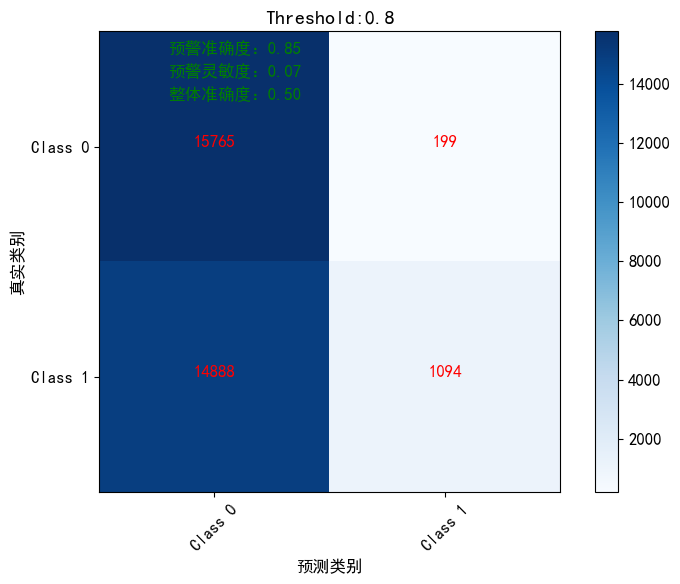

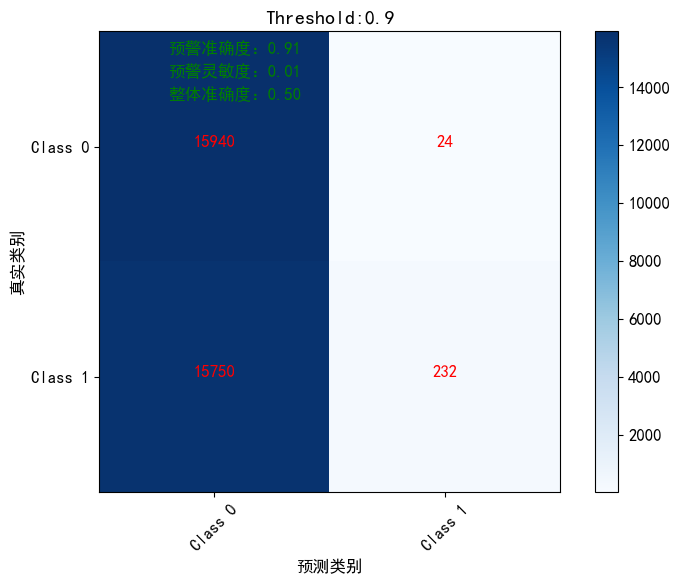

In [68]:
from sklearn.metrics import confusion_matrix
predicted = model(dataset['test_input']).cpu().detach().numpy()
for i in range(10):
    binarized = (predicted >= i/10).astype(int)
    cm = confusion_matrix(dataset['test_label'].cpu(), binarized)
    title=f'Threshold:{i/10}'
    classes = ['Class 0', 'Class 1']
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    normalize = False
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for idx in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, idx, format(cm[idx, j], fmt),
                     horizontalalignment="center",
                     color="red" if cm[idx, j] > thresh else "red")

    plt.ylabel('真实类别')
    plt.xlabel('预测类别')
    
    # 打印指标
    plt.text(-0.2, -0.4, f"预警准确度：{cm[1,1] / (cm[1,1] + cm[0,1]):.2f}", fontsize=12, ha='left', color='green')
    plt.text(-0.2, -0.3, f"预警灵敏度：{cm[1,1] / (cm[1,1] + cm[1,0]):.2f}", fontsize=12, ha='left', color='green')
    plt.text(-0.2, -0.2, f"整体准确度：{(cm[1,1] + cm[1,0]) / (cm[1,1] + cm[1,0] + cm[0,1] + cm[0,0]):.2f}", fontsize=12, ha='left', color='green')
    
    # 检查文件夹是否存在，不存在则创建
    folder = 'KAN'
    if not os.path.exists(folder):
        os.makedirs(folder)
    
    plt.savefig(os.path.join(folder, f'KAN_{i}.png'))
    plt.tight_layout()

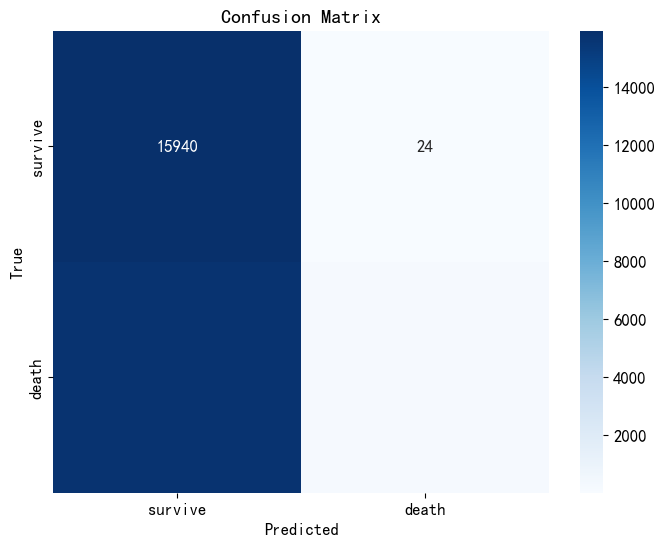

In [67]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=['survive', 'death'], yticklabels=['survive', 'death'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [27]:
predicted = model(dataset['train_input']).cpu().detach().numpy()
for i in range(10):
    binarized_train = (predicted >= i/10).astype(int)
    cm_train = confusion_matrix(dataset['train_label'].cpu(), binarized_train)
    print(cm_train)

array([[118199,  25571],
       [ 82458,  61294]], dtype=int64)

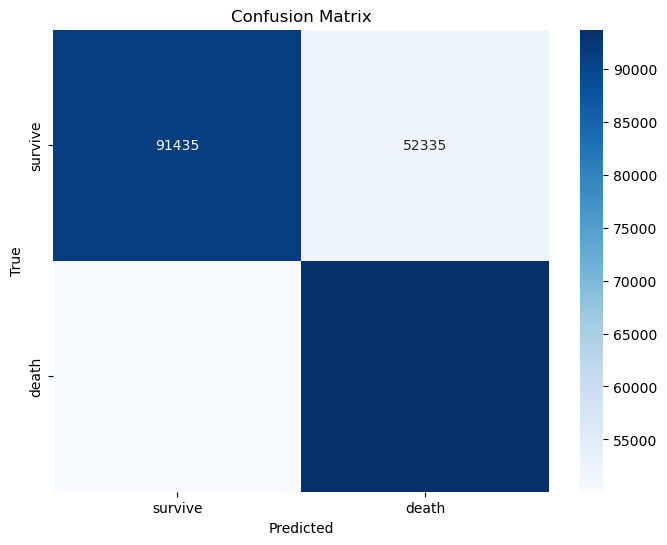

In [25]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, cmap='Blues', fmt='g', xticklabels=['survive', 'death'], yticklabels=['survive', 'death'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [74]:
import torch
import os
# 保存模型参数到文件
folder = 'KAN'
if not os.path.exists(folder):
    os.makedirs(folder)
torch.save(model.state_dict(), os.path.join(folder, "KAN.pth"))

In [75]:
mymodel = KAN([7, 10, 1], device="cuda")
mymodel.load_state_dict(torch.load(os.path.join(folder, "KAN.pth")))


<All keys matched successfully>